In [56]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

# Drug dataset
Imagine that you are a medical researcher compiling data for a study. You have collected data about a set of patients, all of whom suffered from the same illness. During their course of treatment, each patient responded to one of 5 medications, Drug A, Drug B, Drug c, Drug x and y.

Part of your job is to build a model to find out which drug might be appropriate for a future patient with the same illness. The features of this dataset are Age, Sex, Blood Pressure, and the Cholesterol of the patients, and the target is the drug that each patient responded to.

It is a sample of multiclass classifier, and you can use the training part of the dataset to build a decision tree, and then use it to predict the class of a unknown patient, or to prescribe a drug to a new patient.

https://www.kaggle.com/pablomgomez21/drugs-a-b-c-x-y-for-decision-trees

In [4]:
# Import the dataset
df = pd.read_csv("data/drugs.csv")
# Show the first few rows
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


In [6]:
# Look at the total amount of rows and columns
df.shape

(200, 6)

<AxesSubplot:xlabel='Drug', ylabel='count'>

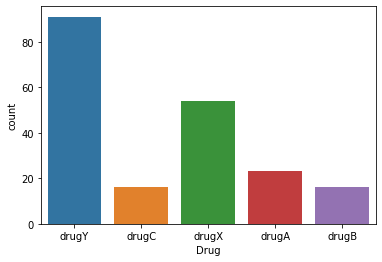

In [31]:
# Show the distribution of the target column
sns.countplot(x='Drug',data=df)

In [36]:
# Split into features and target
X=df.drop("Drug",axis=1)
y=df.Drug

In [38]:
# Find a way to change the categorical (text) features into numeric features.
# Different options are available. The best one being LabelEncoder():
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
# 
# Other options are one-hot encoding and pd.get_dummies functions
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
# https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html

le = LabelEncoder()
X.Sex = le.fit_transform(X.Sex)
X.BP = le.fit_transform(X.BP)
X.Cholesterol = le.fit_transform(X.Cholesterol)
display(X)

,Age,Sex,BP,Cholesterol,Na_to_K
0,23,0,0,0,25.355
1,47,1,1,0,13.093
2,47,1,1,0,10.114
3,28,0,2,0,7.798
4,61,0,1,0,18.043
...,...,...,...,...,...
195,56,0,1,0,11.567
196,16,1,1,0,12.006
197,52,1,2,0,9.894
198,23,1,2,1,14.020


In [27]:
# Split into a training and test set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1)

In [39]:
# Create a random forest classifier model. Set max_depth parameter to 2
# You also might wanna play with the class_weight parameter
model = RandomForestClassifier(max_depth=2,class_weight="balanced")
# Fit the model
model.fit(X_train,y_train)
# Print the score on the test set
model.score(X_test,y_test)

0.9

In [40]:
# Predict values for the test set
y_pred= model.predict(X_test)

# Print a confusion matrix and classification report
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[ 5  0  0  0  0]
 [ 1  2  0  0  0]
 [ 0  0  4  0  0]
 [ 0  0  3  7  0]
 [ 0  0  0  0 18]]
              precision    recall  f1-score   support

       drugA       0.83      1.00      0.91         5
       drugB       1.00      0.67      0.80         3
       drugC       0.57      1.00      0.73         4
       drugX       1.00      0.70      0.82        10
       drugY       1.00      1.00      1.00        18

    accuracy                           0.90        40
   macro avg       0.88      0.87      0.85        40
weighted avg       0.94      0.90      0.90        40



## Hyperparameter optimizations
Use a grid, random or bayes search to do some hyperparameter optimizations.

For possible hyperparameters to tune, take a look at the documentation of random forest trees:

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

Keep max_depth at 1 and/or 2, as otherwise, your tree would get everything right in the training set.

Note there is not really a right answer. It's just about trying different things and seeing if you can implement a search yourself.

In [62]:
# Optimizations
from sklearn.model_selection import GridSearchCV

baseModel=RandomForestClassifier()
parameters=[{
                "n_estimators":[50,100,150],
                "criterion":["gini","entropy"],
                "max_depth":[1,2],
                "max_features":["sqrt","log2",None],
                "class_weight":["balanced","balanced_subsample",None],
                "max_samples":[0.5,0.7,0.9]
            }]

gsearch = GridSearchCV(estimator=baseModel,param_grid=parameters,cv=5,n_jobs=-1,verbose=5)

gsearch.fit(X_train,y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:   36.2s finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'class_weight': ['balanced', 'balanced_subsample',
                                           None],
                          'criterion': ['gini', 'entropy'], 'max_depth': [1, 2],
                          'max_features': ['sqrt', 'log2', None],
                          'max_samples': [0.5, 0.7, 0.9],
                          'n_estimators': [50, 100, 150]}],
             verbose=5)

In [63]:
# Print the score of the best model of your search
print(gsearch.score(X_test,y_test))

# Print the parameters that give you the best model
print(gsearch.best_params_)
print(gsearch.best_estimator_)

0.975
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'max_features': 'sqrt', 'max_samples': 0.5, 'n_estimators': 50}
RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=2, max_features='sqrt', max_samples=0.5,
                       n_estimators=50)


## Boosting
Try now to also create a boosted model for the random forest trees and test the model.

In [65]:
from sklearn.ensemble import GradientBoostingClassifier

# Gradient boosting
clf_gradientboost = GradientBoostingClassifier(n_estimators=100,learning_rate=0.8,max_depth=1)

clf_gradientboost.fit(X_train,y_train)


y_pred = clf_gradientboost.predict(X_test)

print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

              precision    recall  f1-score   support

       drugA       0.83      1.00      0.91         5
       drugB       1.00      0.67      0.80         3
       drugC       1.00      1.00      1.00         4
       drugX       1.00      1.00      1.00        10
       drugY       1.00      1.00      1.00        18

    accuracy                           0.97        40
   macro avg       0.97      0.93      0.94        40
weighted avg       0.98      0.97      0.97        40

[[ 5  0  0  0  0]
 [ 1  2  0  0  0]
 [ 0  0  4  0  0]
 [ 0  0  0 10  0]
 [ 0  0  0  0 18]]
97.5
